In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
albedo_top_half = pd.read_csv("mercury-albedo-top-half.png.csv",header=None)
albedo_bottom_half = pd.read_csv("mercury-albedo-resized-bottom-half.png.csv",header=None)
alsimap = pd.read_csv("alsimap_smooth_032015.png.csv",header=None)
casimap = pd.read_csv("casimap_smooth_032015.png.csv",header=None)
fesimap = pd.read_csv("fesimap_smooth_032015.png.csv",header=None)
mgsimap = pd.read_csv("mgsimap_smooth_032015.png.csv",header=None)
ssimap = pd.read_csv("ssimap_smooth_032015.png.csv",header=None)

In [3]:
def correlation_matrix(dataframe1,dataframe2):
    
    array1 = np.array(dataframe1)
    array1 = np.reshape(array1,(1036800,1))
    array2 = np.array(dataframe2)
    array2 = np.reshape(array2,(1036800,1))
    df = pd.DataFrame(array1,columns=['albedo'])
    df['concentration']= array2    
    corr_matrix = df.corr()
    print("\nCorrelation between the Albedo and Concentration Map\n\n",corr_matrix)
    print("\n\nSummary of the data\n\n",df.describe())    
    
    return df

In [4]:
def test_data(dataframe):
    
    xtrain = np.array(albedo_top_half)
    xtest = np.array(albedo_bottom_half)
    print(dataframe.shape)
    ytrain =np.array(dataframe)
    
    plt.subplots(figsize=(15,8))
    plt.subplot(1, 2, 1)
    plt.imshow(xtrain)
    plt.title("Albedo Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(ytrain)
    plt.title("Concentration Map")
    plt.tight_layout(6)
    plt.show()
    
    return ytrain , xtrain , xtest

In [5]:
def outlier_plots(dataframe):
    
    plt.subplots(figsize=(15,6))
    plt.subplot(1, 2, 1)
    plt.title("Scatter plot Albedo and Concentration")
    plt.scatter(df['albedo'],df['concentration'])
    
    plt.subplot(1, 2, 2)
    green_diamond = dict(markerfacecolor='g', marker='D')
    plt.title('Boxplot for Outlier Detection')
    plt.boxplot(df['concentration'],flierprops=green_diamond)
    plt.tight_layout(6)
    plt.show()
    
    plt.figure(figsize=(8,5))
    plt.title('Distribution of the Concentration')
    plt.hist(df['concentration'])
    plt.show()

In [6]:
def outlier_detection(xtrain,ytrain,contamination):
    
    plt.figure(figsize=(10,7))
    plt.scatter(xtrain, ytrain,s=0.05)
    plt.title('Before Outlier Removal')
    plt.show()
    
    iso = IsolationForest(contamination=contamination)
    yhat = iso.fit_predict(ytrain)
    mask = yhat != -1
    xtrain, ytrain = xtrain[mask, :], ytrain[mask]
    shape = xtrain.shape
    
    plt.figure(figsize=(10,7))
    plt.scatter(xtrain, ytrain,s=0.05)
    plt.title('After Outlier Removal')
    plt.show()
    
    print(shape)
    print(iso.get_params(deep=True))
    
    return xtrain, ytrain, shape

In [7]:
def visualise_maps(array):
    
    plt.figure(figsize=(10,5))
    plt.title("Concentration Map Post Outlier Removal")
    sns.heatmap(array,xticklabels=0,yticklabels=0, cmap='viridis')

In [8]:
def model_application(xtrain, xtest, ytrain):
    
    model = Sequential()
    model.add(Dense(32, input_shape=(1440,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1440, activation='linear'))
    model.summary()
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    history = model.fit(xtrain, ytrain, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)
    ypredicted= model.predict(xtest)
    
    return history,model,ypredicted

In [9]:
def visualise_performance(model,history,xtest,ypredicted):
    
    print(history.history.keys())
    plt.subplots(figsize=(15,6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss for Training Data')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.title("Predicted values for Test Data")
    plt.scatter(xtest,ypredicted,alpha=0.09,s=0.1)
    plt.legend(['Predicted'], loc='upper left')
    plt.tight_layout(4)
    plt.show()

In [10]:
def visualise_predictions(xtest,ypredicted):
    
    plt.subplots(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(xtest)
    plt.title('Bottom Half Albedo')
    plt.subplot(1, 2, 2)
    plt.imshow(ypredicted,cmap='rainbow')
    plt.title('Predicted Concentration in Bottom Half')
    plt.tight_layout(4)
    plt.show()
    
    plt.subplots(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.hist(xtest)
    plt.title('Distribution of Albedo Bottom Half')
    plt.subplot(2, 2, 2)
    plt.hist(xtrain)
    plt.title('Distribution of Albedo Top Half')
    plt.tight_layout(4)
    plt.show()
    
    plt.subplots(figsize=(15, 11))
    plt.subplot(3, 2, 1)
    plt.hist(ypredicted)
    plt.title('Concentration Distribution Predicted on Bottom Half')   
    plt.subplot(3, 2, 2)
    plt.hist(ytrain)
    plt.title('Concentration Distribution on Top Half')
    plt.tight_layout(4)
    plt.show()
    

AlSi Map

In [11]:
df = correlation_matrix(albedo_top_half,alsimap)


Correlation between the Albedo and Concentration Map

                  albedo  concentration
albedo         1.000000       0.101683
concentration  0.101683       1.000000


Summary of the data

              albedo  concentration
count  1.036800e+06   1.036800e+06
mean   4.144590e-01   7.510351e-01
std    1.165033e-01   1.989632e-01
min    0.000000e+00   0.000000e+00
25%    3.372549e-01   7.137255e-01
50%    4.039216e-01   8.039216e-01
75%    4.862745e-01   8.745098e-01
max    1.000000e+00   1.000000e+00


> Observation: Here we observe there is no linear correlation between the data of albedo and concentration map before the outlier removal 

(720, 1440)


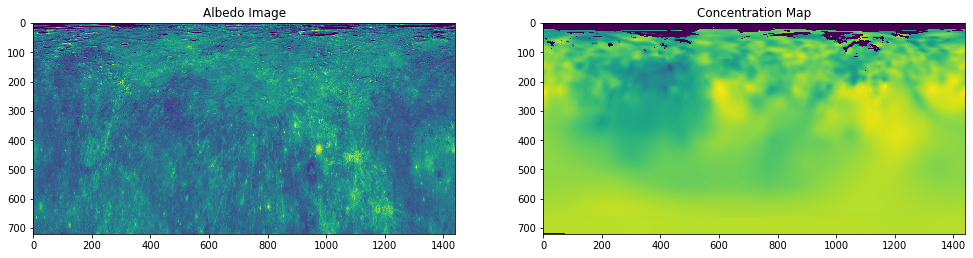

In [12]:
ytrain , xtrain , xtest = test_data(alsimap)

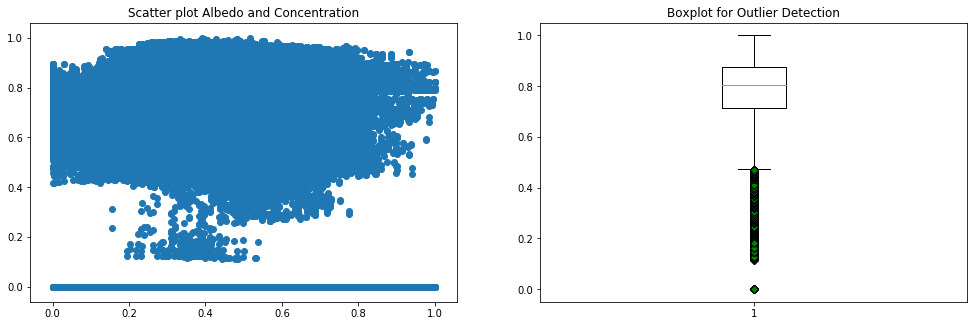

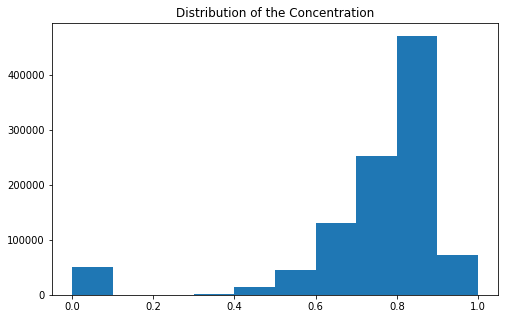

In [13]:
outlier_plots(df)

> Observation: We see significant amount of outlier presence and observe the gaps in data through scatter plot and through histogram we observe a continous data flow from 0.3 to 1.0 while there is some distribution near 0.0 which can create discontinuity in predictions as well.

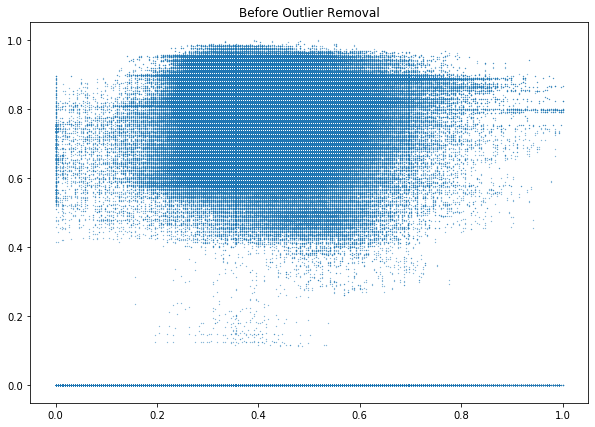

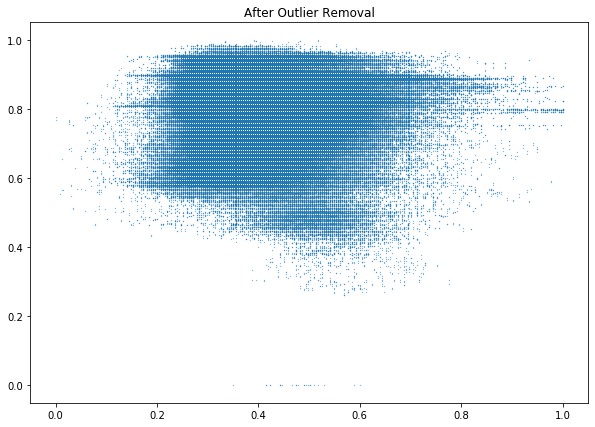

(590, 1440)
{'behaviour': 'deprecated', 'bootstrap': False, 'contamination': 0.18, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [14]:
xtrain, ytrain , shape = outlier_detection(xtrain,ytrain,0.18)

> We observe a decent performance of Isolation Forest Outlier Removal Algorithm in case of AlSi Map. The gaps are completely removed.

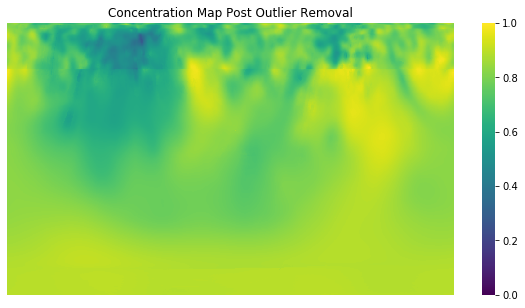

In [15]:
# Concentration Map Post Outlier Removal
visualise_maps(ytrain)

In [16]:
history,model,ypredicted = model_application(xtrain, xtest, ytrain)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                46112     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1440)              24480     
Total params: 71,120
Trainable params: 71,120
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
10/10 [==============================] - 1s 98ms/step - loss: 0.6140 - mse: 0.6140 - mae: 0.7753 - val_loss: 0.6908 - val_mse: 0.6908 - val_mae: 0.8050
Epoch 2/150
10/10 [==============================] - 0s 7ms/step - loss: 0.4833 - mse: 0.4833 - mae: 0.6349 - val_loss: 0.3655 - val_mse: 0.3655 - val_mae: 0.4918
Epoch 3/150
10/10 [==============================] - 0s

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


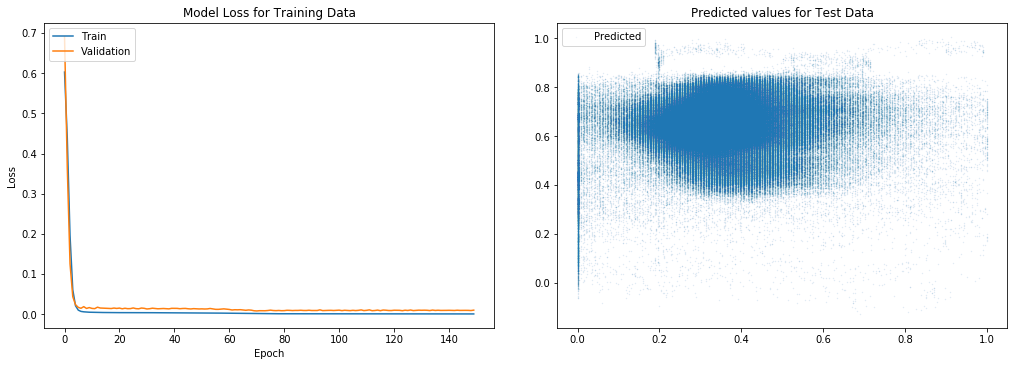

In [17]:
visualise_performance(model,history,xtest,ypredicted)

> The loss for validation and training is fairly less and generates a gradually decreasing curve

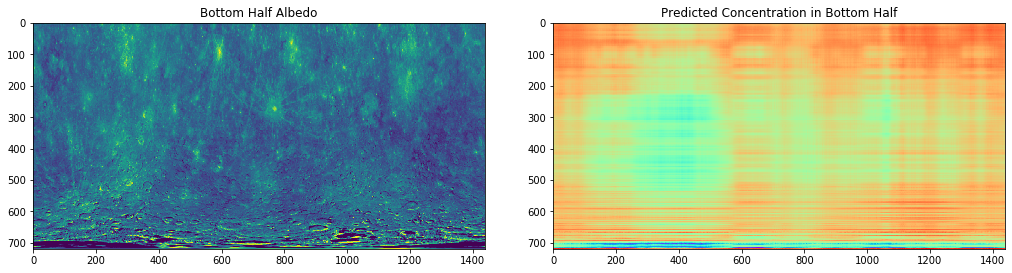

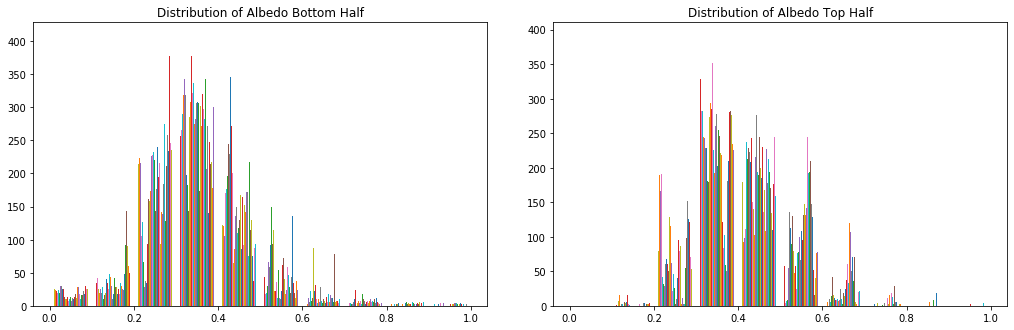

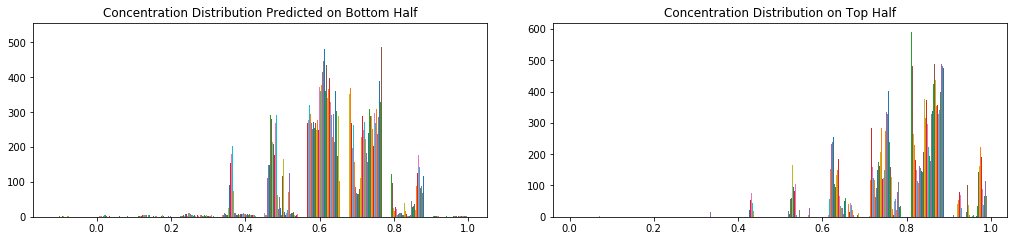

In [18]:
visualise_predictions(xtest,ypredicted)

CaSi Map

In [19]:
df = correlation_matrix(albedo_top_half,casimap)


Correlation between the Albedo and Concentration Map

                  albedo  concentration
albedo         1.000000       0.002648
concentration  0.002648       1.000000


Summary of the data

              albedo  concentration
count  1.036800e+06   1.036800e+06
mean   4.144590e-01   4.086300e-01
std    1.165033e-01   2.254984e-01
min    0.000000e+00   0.000000e+00
25%    3.372549e-01   4.274510e-01
50%    4.039216e-01   4.941176e-01
75%    4.862745e-01   5.333334e-01
max    1.000000e+00   1.000000e+00


> Observation: Here we observe there is no linear correlation between the data of albedo and concentration map before the outlier removal 

(720, 1440)


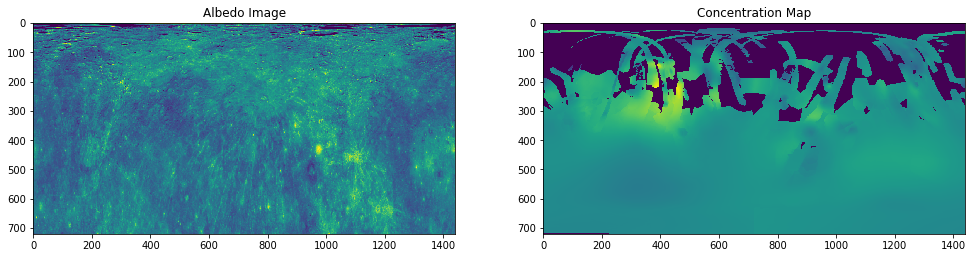

In [20]:
ytrain , xtrain , xtest = test_data(casimap)

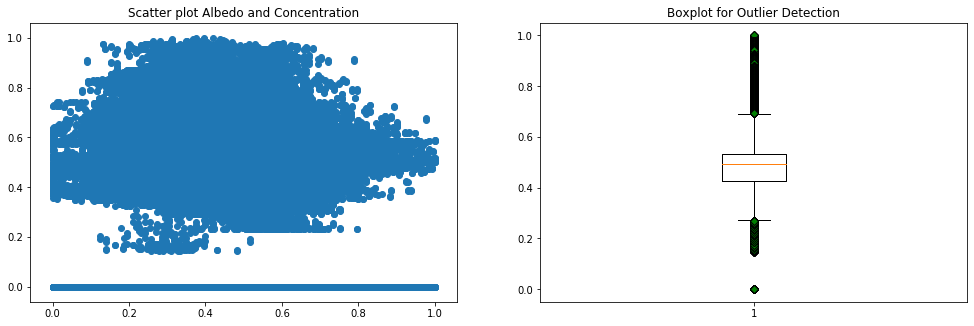

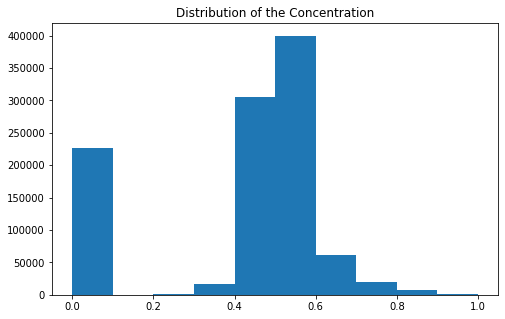

In [21]:
outlier_plots(df)

> Observation: We see significant amount of outlier presence and observe the gaps in data through scatter plot and through histogram we observe a continous data flow from 0.2 to 1.0 while there is some distribution near 0.0 which can create discontinuity in predictions as well.

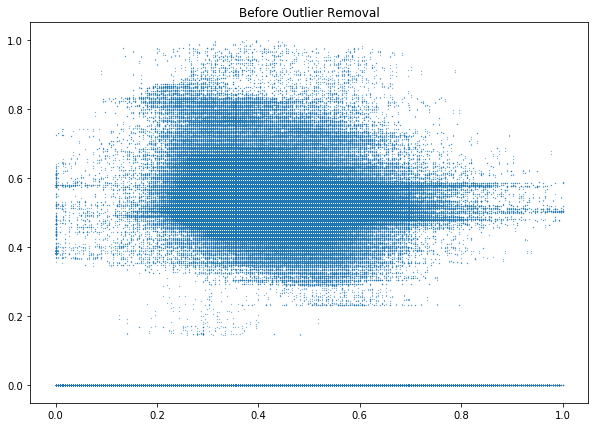

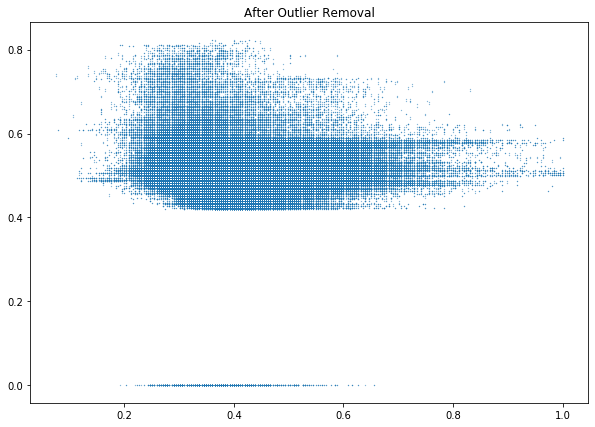

(402, 1440)
{'behaviour': 'deprecated', 'bootstrap': False, 'contamination': 'auto', 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [22]:
xtrain, ytrain , shape = outlier_detection(xtrain,ytrain,'auto')

> We observe a not a great performance of Isolation Forest Outlier Removal Algorithm in case of CaSi Map. The gaps are removed to some extent and lot of training data around dense plot is removed which may cause biased predictions. Other Outlier Removal Algorithm like Minimum Covariance Determinant, Local Outlier Factor, One-Class SVM do not work properly in this case.

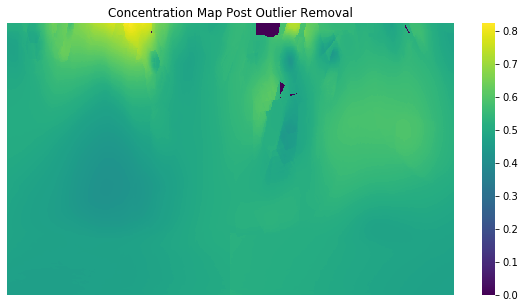

In [23]:
visualise_maps(ytrain)

In [24]:
history,model,ypredicted = model_application(xtrain, xtest, ytrain)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                46112     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1440)              24480     
Total params: 71,120
Trainable params: 71,120
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
7/7 [==============================] - 0s 33ms/step - loss: 0.2653 - mse: 0.2653 - mae: 0.5064 - val_loss: 0.1900 - val_mse: 0.1900 - val_mae: 0.3948
Epoch 2/150
7/7 [==============================] - 0s 14ms/step - loss: 0.1991 - mse: 0.1991 - mae: 0.3957 - val_loss: 0.1177 - val_mse: 0.1177 - val_mae: 0.2753
Epoch 3/150
7/7 [==============================] - 0s 14

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


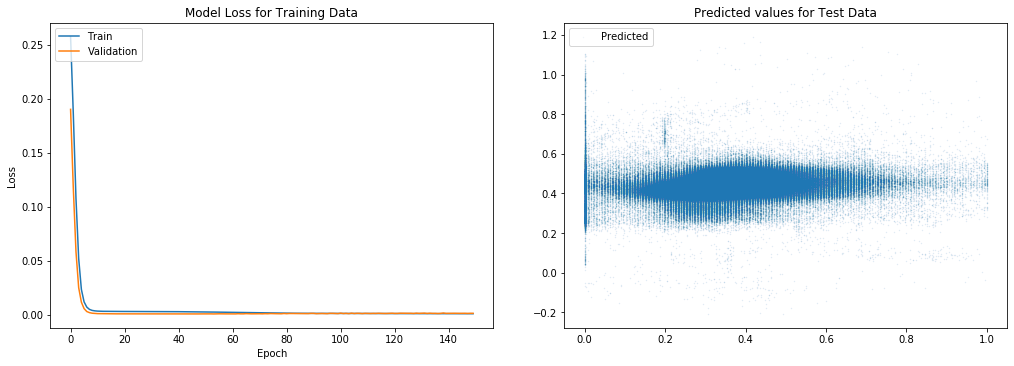

In [25]:
visualise_performance(model,history,xtest,ypredicted)

> The loss for validation and training is fairly less and generates a steeply decreasing curve

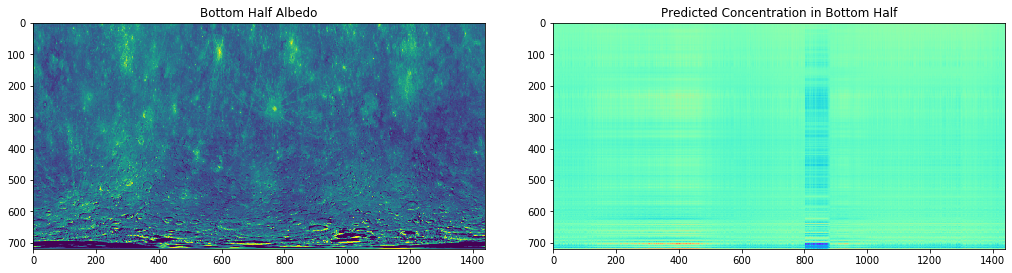

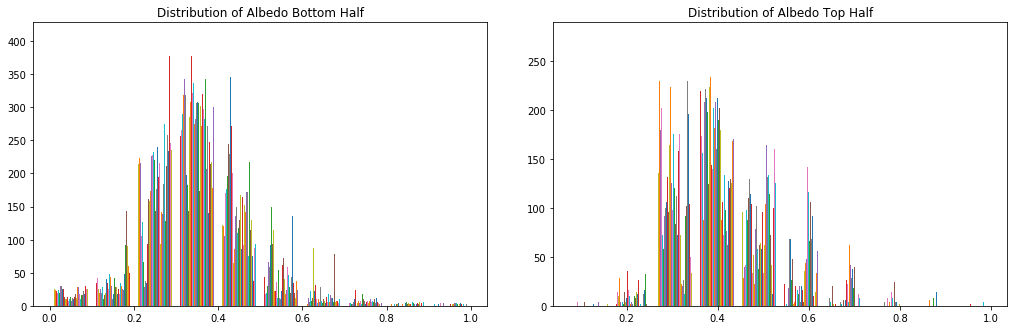

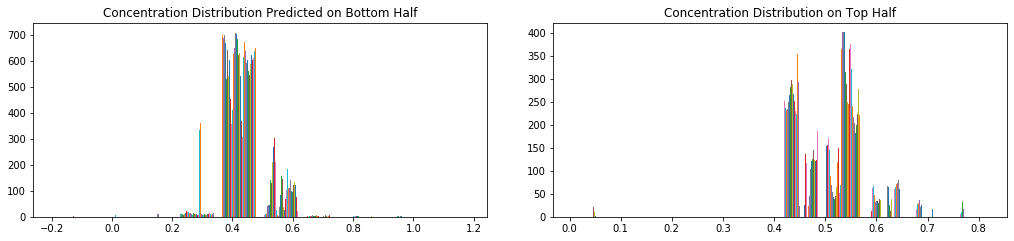

In [26]:
visualise_predictions(xtest,ypredicted)

FeSi Map

In [27]:
df = correlation_matrix(albedo_top_half,fesimap)


Correlation between the Albedo and Concentration Map

                  albedo  concentration
albedo         1.000000      -0.045356
concentration -0.045356       1.000000


Summary of the data

              albedo  concentration
count  1.036800e+06   1.036800e+06
mean   4.144590e-01   3.138895e-01
std    1.165033e-01   2.891811e-01
min    0.000000e+00   0.000000e+00
25%    3.372549e-01   0.000000e+00
50%    4.039216e-01   4.549020e-01
75%    4.862745e-01   5.607843e-01
max    1.000000e+00   1.000000e+00


> Observation: Here we observe there is no linear correlation between the data of albedo and concentration map before the outlier removal 

(720, 1440)


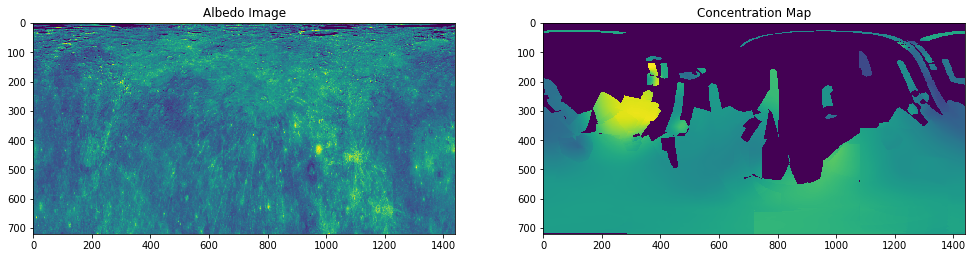

In [28]:
ytrain , xtrain , xtest = test_data(fesimap)

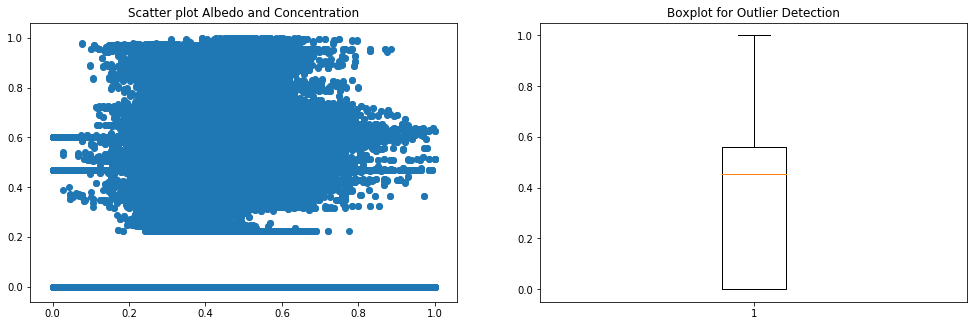

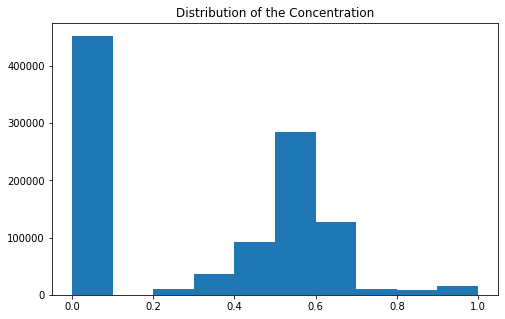

In [29]:
outlier_plots(df)

> Observation: We see significant amount of outlier presence and observe the gaps in data through scatter plot and through histogram we observe a continous data flow from 0.2 to 1.0 while there is some distribution near 0.0 which can create discontinuity in predictions as well.

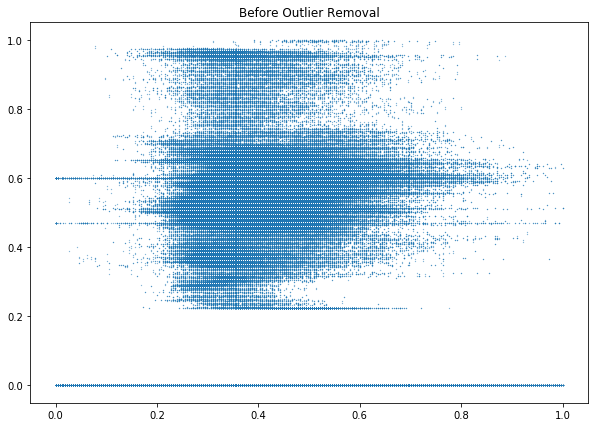

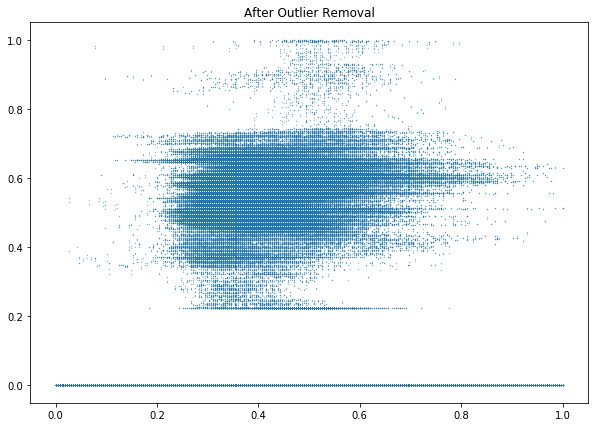

(471, 1440)
{'behaviour': 'deprecated', 'bootstrap': False, 'contamination': 'auto', 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [30]:
xtrain, ytrain , shape = outlier_detection(xtrain,ytrain,'auto')

> We do not observe a great performance of Isolation Forest Outlier Removal Algorithm in case of FeSi Map. The gaps are not removed at all and lot of training data around dense plot is removed which may cause biased and wrong predictions. Other Outlier Removal Algorithm like Minimum Covariance Determinant, Local Outlier Factor, One-Class SVM also do not work properly in this case.

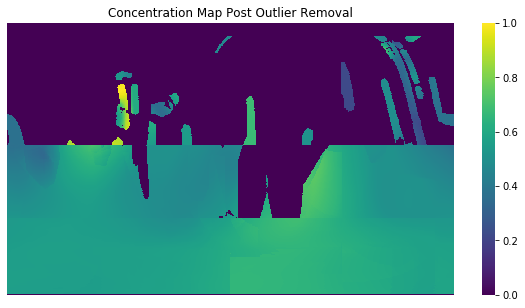

In [31]:
visualise_maps(ytrain)

In [32]:
history,model,ypredicted = model_application(xtrain, xtest, ytrain)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                46112     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1440)              24480     
Total params: 71,120
Trainable params: 71,120
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
8/8 [==============================] - 0s 26ms/step - loss: 0.1301 - mse: 0.1301 - mae: 0.2594 - val_loss: 0.3320 - val_mse: 0.3320 - val_mae: 0.5709
Epoch 2/150
8/8 [==============================] - 0s 12ms/step - loss: 0.1186 - mse: 0.1186 - mae: 0.2493 - val_loss: 0.2775 - val_mse: 0.2775 - val_mae: 0.5125
Epoch 3/150
8/8 [==============================] - 0s 11

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


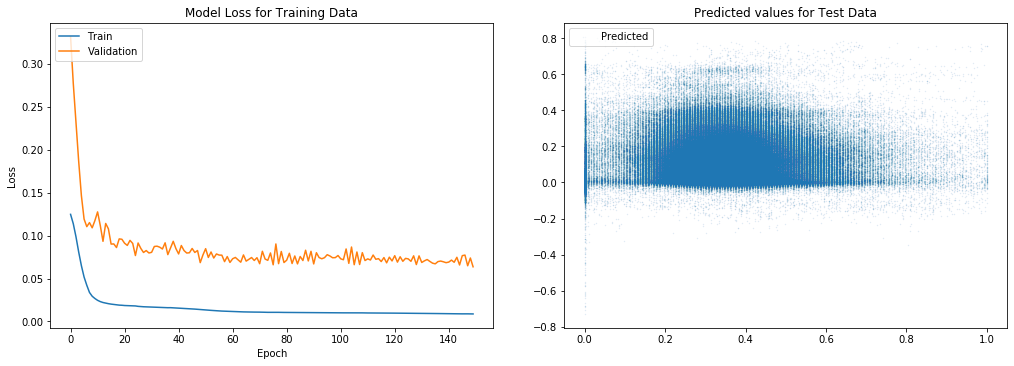

In [33]:
visualise_performance(model,history,xtest,ypredicted)

> The loss for validation and training is a decreasing curve but highly noisy and fluctuating depicting poor performance of the deep learning model.

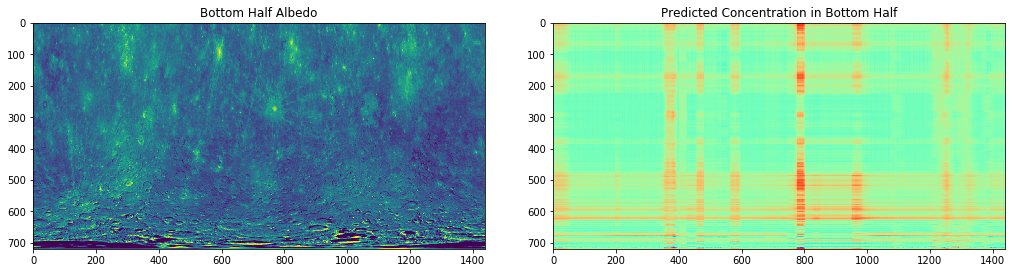

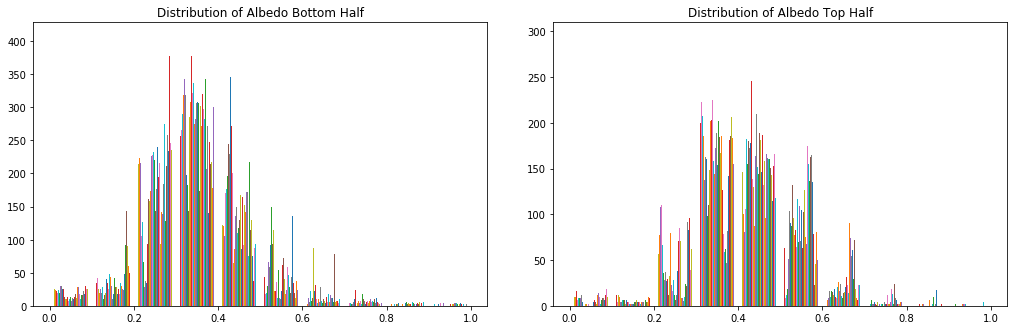

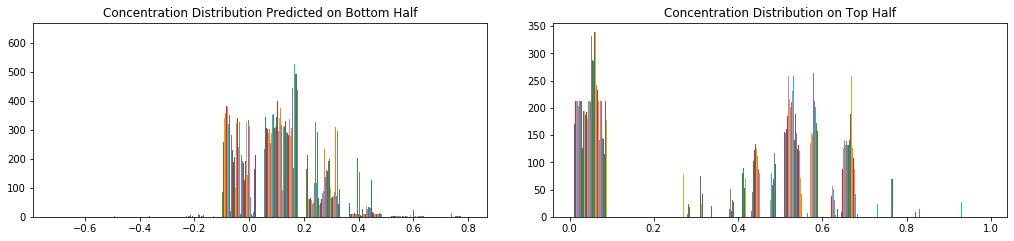

In [34]:
visualise_predictions(xtest,ypredicted)

MgSi Map

In [35]:
df = correlation_matrix(albedo_top_half,mgsimap)


Correlation between the Albedo and Concentration Map

                  albedo  concentration
albedo         1.000000       0.084904
concentration  0.084904       1.000000


Summary of the data

              albedo  concentration
count  1.036800e+06   1.036800e+06
mean   4.144590e-01   5.303197e-01
std    1.165033e-01   1.432387e-01
min    0.000000e+00   0.000000e+00
25%    3.372549e-01   4.980392e-01
50%    4.039216e-01   5.411765e-01
75%    4.862745e-01   5.803922e-01
max    1.000000e+00   1.000000e+00


> Observation: Here we observe there is no linear correlation between the data of albedo and concentration map before the outlier removal 

(720, 1440)


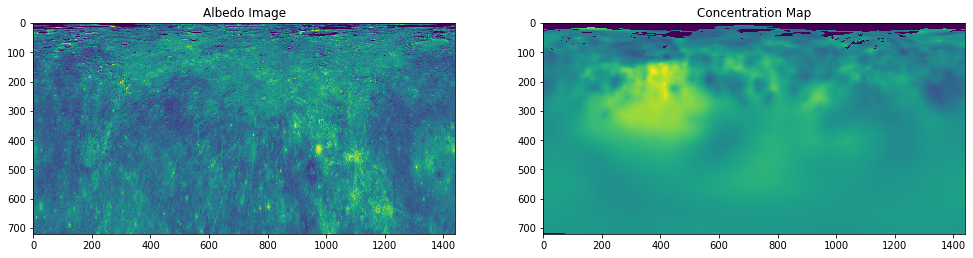

In [36]:
ytrain , xtrain , xtest = test_data(mgsimap)

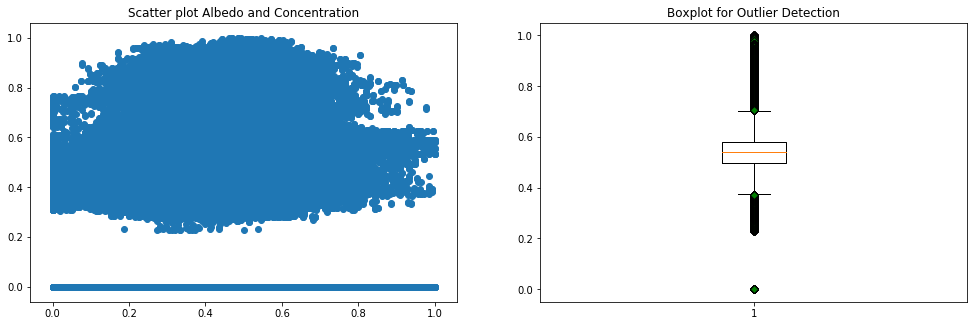

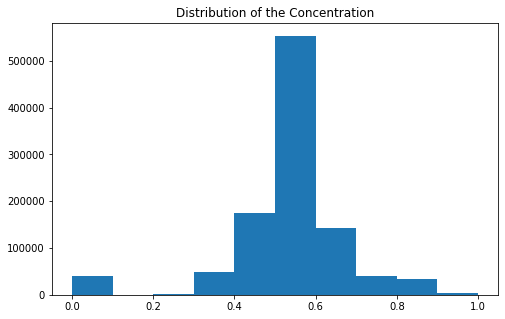

In [37]:
outlier_plots(df)

> Observation: We see significant amount of outlier presence and observe the gaps in data through scatter plot and through histogram we observe a continous data flow from 0.2 to 1.0 while there is some distribution near 0.0 which can create discontinuity in predictions as well.

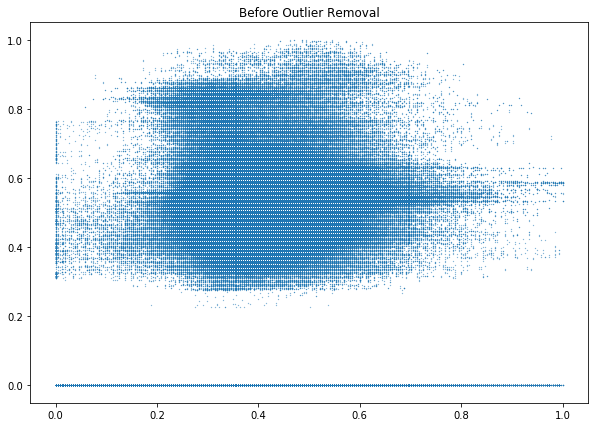

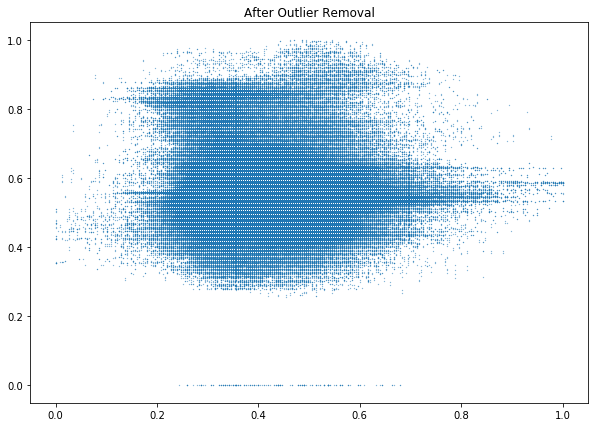

(590, 1440)
{'behaviour': 'deprecated', 'bootstrap': False, 'contamination': 0.18, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [38]:
xtrain, ytrain , shape = outlier_detection(xtrain,ytrain,0.18)

> We observe a decent performance of Isolation Forest Outlier Removal Algorithm in case of MgSi Map. The gaps are completely removed.

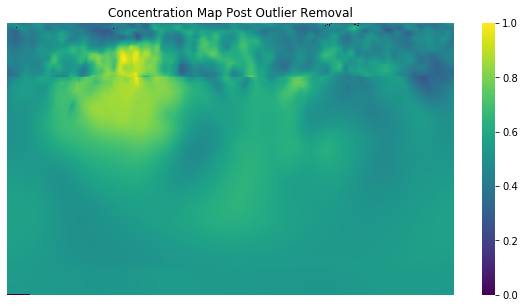

In [39]:
visualise_maps(ytrain)

In [40]:
history,model,ypredicted = model_application(xtrain, xtest, ytrain)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                46112     
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1440)              24480     
Total params: 71,120
Trainable params: 71,120
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
10/10 [==============================] - 1s 24ms/step - loss: 0.3136 - mse: 0.3136 - mae: 0.5411 - val_loss: 0.1791 - val_mse: 0.1791 - val_mae: 0.3543
Epoch 2/150
10/10 [==============================] - 0s 10ms/step - loss: 0.1715 - mse: 0.1715 - mae: 0.3353 - val_loss: 0.0576 - val_mse: 0.0576 - val_mae: 0.1770
Epoch 3/150
10/10 [==============================] -

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


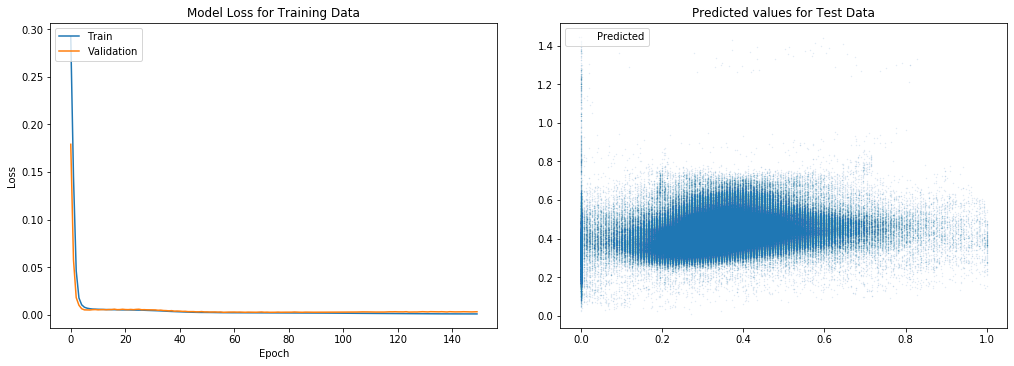

In [41]:
visualise_performance(model,history,xtest,ypredicted)

> The loss for validation and training is fairly less and generates a steeply decreasing curve. Overfitting could be an issue here as there is flatness in the graph. 

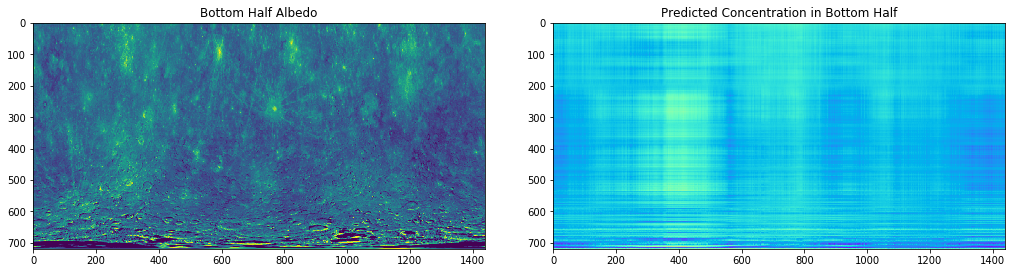

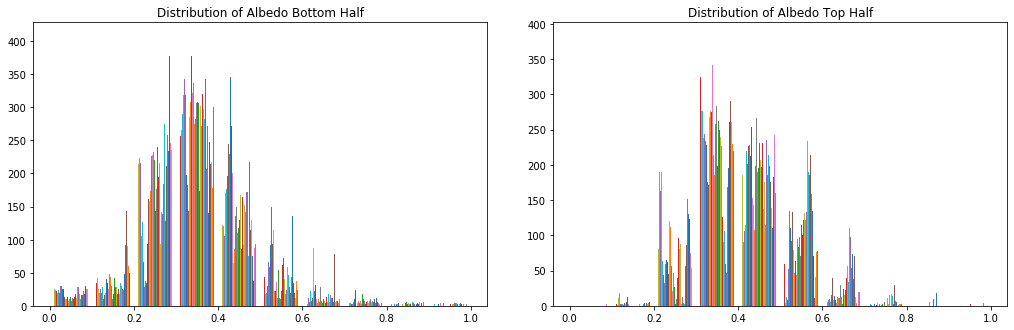

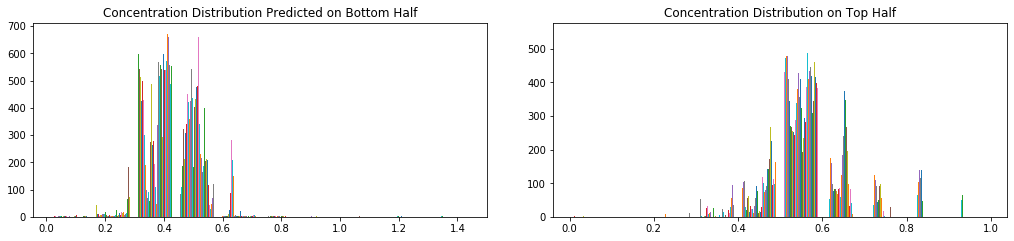

In [42]:
visualise_predictions(xtest,ypredicted)

Ssi Map

In [43]:
df = correlation_matrix(albedo_top_half,ssimap)


Correlation between the Albedo and Concentration Map

                 albedo  concentration
albedo         1.00000       -0.02485
concentration -0.02485        1.00000


Summary of the data

              albedo  concentration
count  1.036800e+06   1.036800e+06
mean   4.144590e-01   3.859588e-01
std    1.165033e-01   2.304556e-01
min    0.000000e+00   0.000000e+00
25%    3.372549e-01   3.529412e-01
50%    4.039216e-01   4.509804e-01
75%    4.862745e-01   5.098040e-01
max    1.000000e+00   1.000000e+00


> Observation: Here we observe there is no linear correlation between the data of albedo and concentration map before the outlier removal 

(720, 1440)


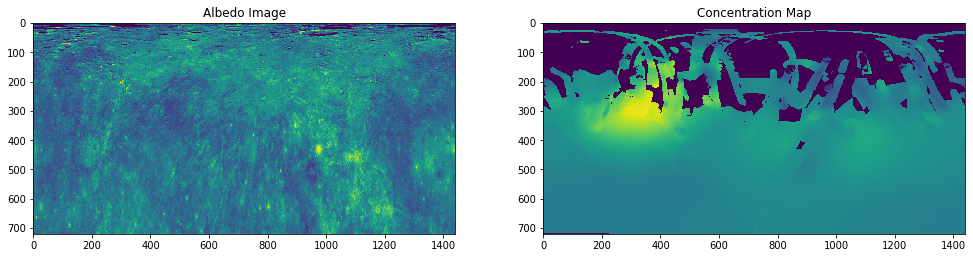

In [44]:
ytrain , xtrain , xtest = test_data(ssimap)

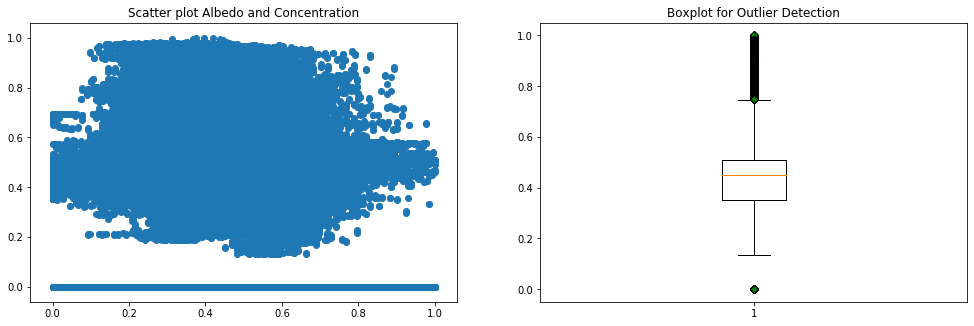

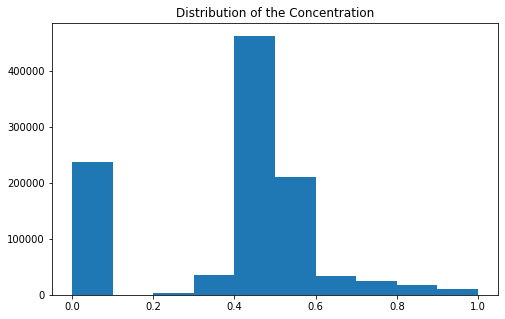

In [45]:
outlier_plots(df)

> Observation: We see significant amount of outlier presence and observe the gaps in data through scatter plot and through histogram we observe a continous data flow from 0.2 to 1.0 while there is some distribution near 0.0 which can create discontinuity in predictions as well.

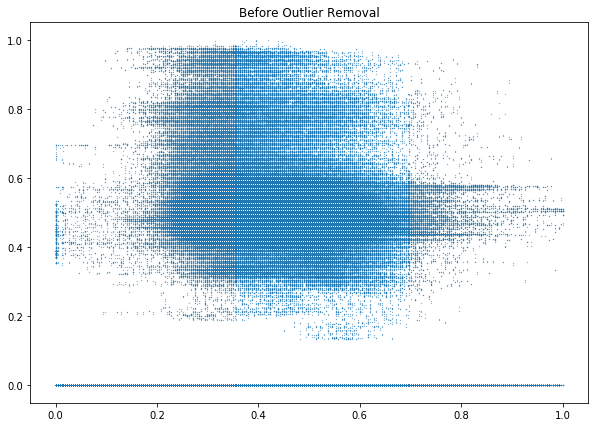

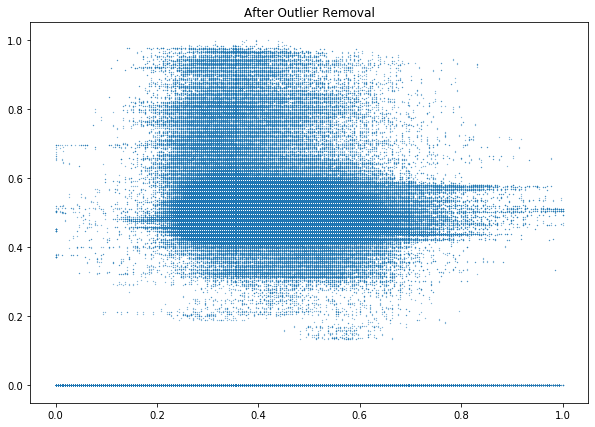

(576, 1440)
{'behaviour': 'deprecated', 'bootstrap': False, 'contamination': 0.2, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [46]:
xtrain, ytrain , shape = outlier_detection(xtrain,ytrain,0.2)

> We do not observe a great performance of Isolation Forest Outlier Removal Algorithm in case of SSi Map. The gaps are not removed and training data around dense plot is not removed which may cause biased and wrong predictions. Other Outlier Removal Algorithm like Minimum Covariance Determinant, Local Outlier Factor, One-Class SVM do not work properly in this case.

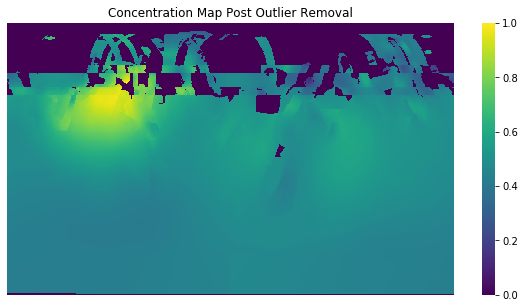

In [47]:
visualise_maps(ytrain)

In [48]:
history,model,ypredicted = model_application(xtrain, xtest, ytrain)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                46112     
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 1440)              24480     
Total params: 71,120
Trainable params: 71,120
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
10/10 [==============================] - 0s 20ms/step - loss: 0.2157 - mse: 0.2157 - mae: 0.4114 - val_loss: 0.1363 - val_mse: 0.1363 - val_mae: 0.3278
Epoch 2/150
10/10 [==============================] - 0s 8ms/step - loss: 0.1539 - mse: 0.1539 - mae: 0.3313 - val_loss: 0.0580 - val_mse: 0.0580 - val_mae: 0.1884
Epoch 3/150
10/10 [==============================] - 

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


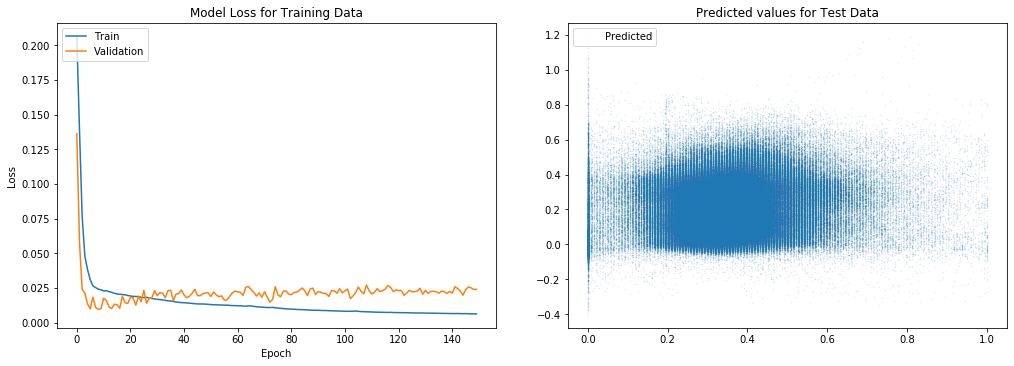

In [49]:
visualise_performance(model,history,xtest,ypredicted)

> The loss for validation and training is a decreasing curve but highly noisy and fluctuating depicting poor performance of the deep learning model.

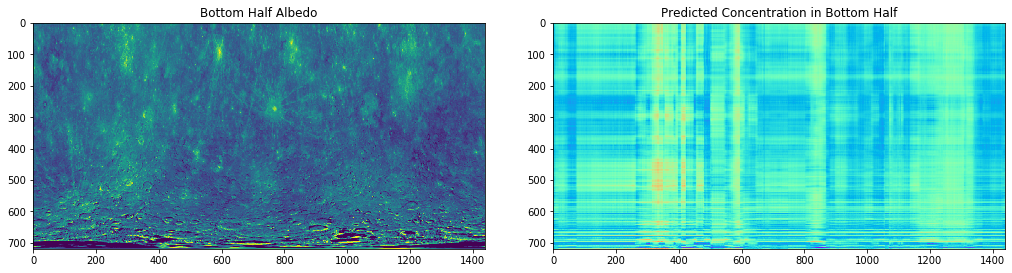

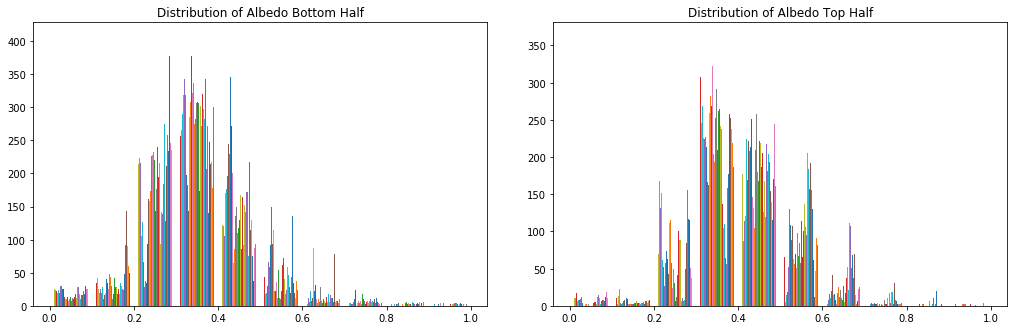

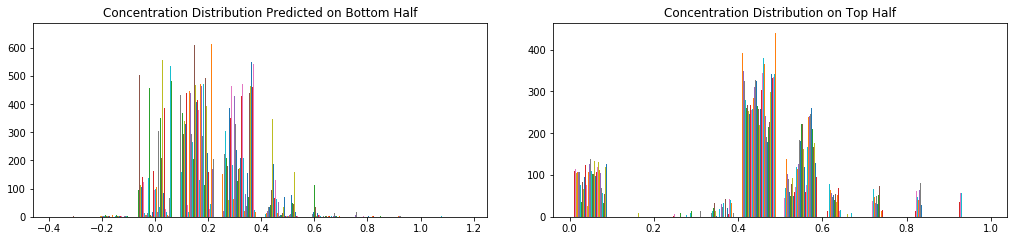

In [50]:
visualise_predictions(xtest,ypredicted)

### Deductions

* The presence of gaps makes the predictions susceptible to error if not removed. 
* No linear relationship was observed before outlier removal.
* Isolation Forest Outlier Removal Algorithm does well for Al and Mg while it does an average job for Ca (in auto contamination) partially. Other Outlier Removal Algorithm like Minimum Covariance Determinant, Local Outlier Factor, One-Class SVM do not work properly with any maps.
* In future we can opt for manual outlier removal methods like Z-Score, IQR method etc. observe the performance for deep earning models. Also we might see a change in linear relationship after removal which could help us in trying the performance of other regression models like Linear Regression etc.
* Data visualisation can be significantly improved and scaling can be better. 